# AirBNB data exploration

In this notebook, we're going to try to answer the following questions:

- What is affecting price variations?
- Does it cares that a host has several listings on price variations?
- When is a property on high or low price? (predictable)

In [1]:
# Required imports for the project
import pandas as pd
import numpy as np
import seaborn as sns
import swifter
import dask.dataframe as dd


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import matplotlib

#Custom function to download datasets from airbnb site.
from utils import download_datasets

In [2]:
#datasets to download
datasets_urls_boston = [
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/calendar.csv.gz'
]

datasets_urls_seattle = [
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/calendar.csv.gz'
]
datasets_urls_austin = [
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/calendar.csv.gz'
]

download_datasets(datasets_urls_boston, 'boston_')
download_datasets(datasets_urls_seattle, 'seattle_')
download_datasets(datasets_urls_austin, 'austin_')


datasets_cities = [
    'seattle',
    'boston',
    'austin'
]

datasets_cities = ['seattle', 'austin', 'boston']

File: boston_listings.csv.gz, in cache
File: boston_calendar.csv.gz, in cache
File: seattle_listings.csv.gz, in cache
File: seattle_calendar.csv.gz, in cache
File: austin_listings.csv.gz, in cache
File: austin_calendar.csv.gz, in cache


In [3]:
#Reading files and loading data into Dataframe

listings = []
calendar = []

for city in datasets_cities:
    listings += [pd.read_csv(city+'_listings.csv.gz', index_col=0, low_memory=False)]
    calendar += [pd.read_csv(city+'_calendar.csv.gz', parse_dates=['date'], low_memory=False)]

listings = pd.concat(listings)
calendar = pd.concat(calendar)


In [4]:
# Data cleanning

#transform 't' or 'f' into True or False values.
calendar.available = calendar.available.apply(lambda x: x == "t")
#remove $ sign and parse the value as numeric.
calendar.price = calendar.price.apply(lambda x: float(str(x).replace("$","").replace(",","")))

calendar.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

In [5]:
calendar = calendar.reset_index(drop=True)

In [6]:
calendar['price'].describe()

count    3.605498e+06
mean     2.647941e+02
std      4.437125e+02
min      1.000000e+00
25%      9.100000e+01
50%      1.540000e+02
75%      2.900000e+02
max      1.000000e+04
Name: price, dtype: float64

In [7]:
calendar.groupby('listing_id').count().mean()

date         365.000000
available    365.000000
price        138.833192
dtype: float64

Data per listing is related to a entire year

In [8]:
%%time
calendar['year'] = 0
calendar['month'] = 0
calendar['day'] = 0
def date_to_cols(x):
    x = x.copy()
    x.year = x.date.year
    x.month = x.date.month
    x.day = x.date.day
    return x
calendar = calendar.swifter.apply(lambda x: date_to_cols(x), axis=1)
#calendar = calendar.apply(date_to_cols, axis=1, meta=calendar)


Wall time: 4min 58s


In [10]:
#calendar = calendar.drop(['date'], axis=1)
stats_calendar = calendar.price.describe()

In [11]:
calendar['price_per_listing'] = 0.0
calendar = calendar.fillna(0)

def apply_per_listing(df):
    df.price_per_listing = MinMaxScaler().fit_transform(df.price.values.reshape(-1, 1))
    return df

In [12]:
ddf = dd.from_pandas(calendar, npartitions=6)

In [14]:
%%time
calendar = ddf.groupby('listing_id').apply(apply_per_listing, meta=ddf).compute()

Wall time: 34.3 s


C:\Users\0xffa\AppData\Local\conda\conda\envs\Devel\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\0xffa\AppData\Local\conda\conda\envs\Devel\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\0xffa\AppData\Local\conda\conda\envs\Devel\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\0xffa\AppData\Local\conda\conda\envs\Devel\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\0xffa\AppData\Local\conda\conda\envs\Devel\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel p

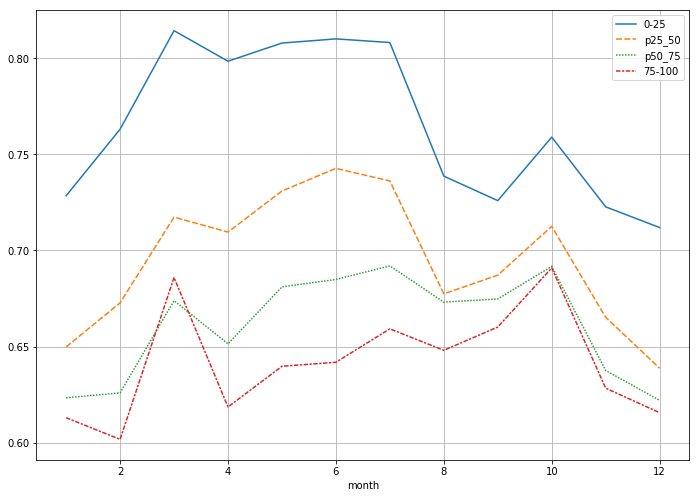

In [74]:
p25_50 = calendar[calendar.price <= stats_calendar['50%']][calendar.price > stats_calendar['25%']][calendar.available].groupby(["month"]).price_per_listing.mean()
p50_75 = calendar[calendar.price <= stats_calendar['75%']][calendar.price > stats_calendar['50%']][calendar.available].groupby(["month"]).price_per_listing.mean()
p25 = calendar[calendar.price <= stats_calendar['25%']][calendar.available].groupby(["month"]).price_per_listing.mean()
p75 = calendar[calendar.price > stats_calendar['75%']][calendar.available].groupby(["month"]).price_per_listing.mean()



res = pd.concat([p25, p25_50, p50_75,  p75], axis=1)
res.columns = ['0-25', 'p25_50', 'p50_75','75-100']


res
fig, ax = plt.subplots()
plt.grid(True)
fig.set_size_inches(11.7, 8.27)


sns.lineplot(data=res)

In [81]:
p25_50 = calendar[calendar.price <= stats_calendar['50%']][calendar.price > stats_calendar['25%']].groupby(["month"]).available.sum()
p50_75 = calendar[calendar.price <= stats_calendar['75%']][calendar.price > stats_calendar['50%']].groupby(["month"]).available.sum()
p25 = calendar[calendar.price <= stats_calendar['25%']].groupby(["month"]).available.sum()
p75 = calendar[calendar.price > stats_calendar['75%']].groupby(["month"]).available.sum()



res = pd.concat([p25, p25_50, p50_75,  p75], axis=1)
res.columns = ['0-25', 'p25_50', 'p50_75','75-100']


res


C:\Users\0xffa\AppData\Local\conda\conda\envs\Devel\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\0xffa\AppData\Local\conda\conda\envs\Devel\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,0-25,p25_50,p50_75,75-100
month,,,,
1,100618.0,105997.0,90183.0,72023.0
2,70012.0,78048.0,71128.0,60951.0
3,60524.0,66445.0,66755.0,78161.0
4,61187.0,65195.0,66520.0,69966.0
5,60594.0,61028.0,66032.0,73510.0
6,57234.0,55207.0,63612.0,70956.0
7,59711.0,58088.0,65023.0,74593.0
8,58646.0,56645.0,61102.0,66796.0
9,79455.0,70074.0,75755.0,79556.0


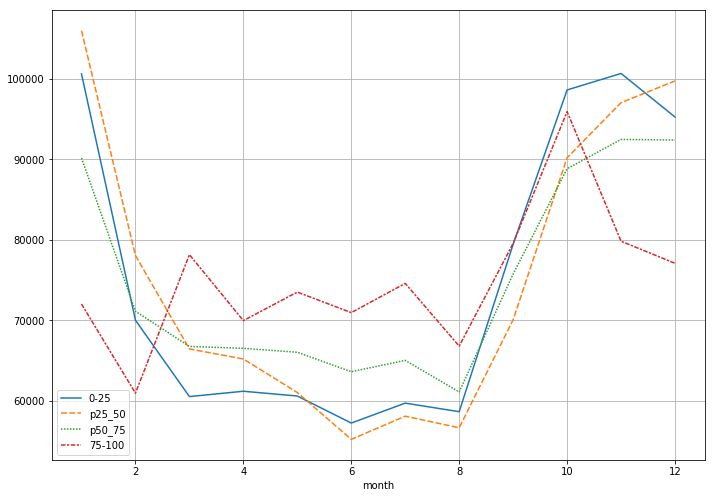

In [80]:
fig, ax = plt.subplots()
plt.grid(True)
fig.set_size_inches(11.7, 8.27)


sns.lineplot(data=res);

C:\Users\0xffa\AppData\Local\conda\conda\envs\Devel\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


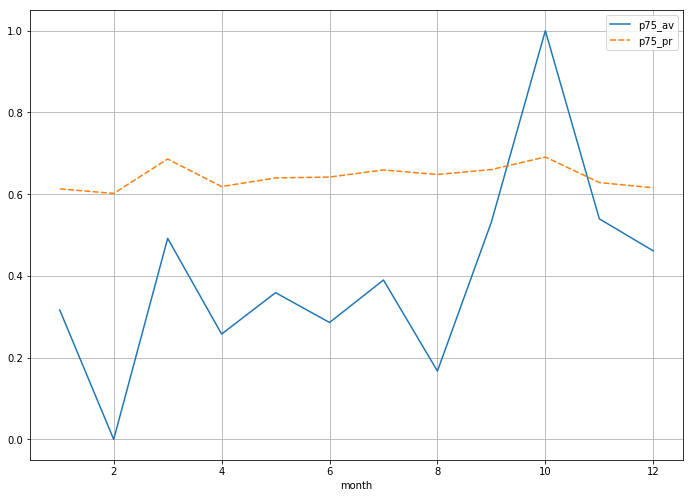

In [105]:
p75 = calendar[calendar.price > stats_calendar['75%']].groupby(["month"]).available.sum()

scaler = MinMaxScaler()
scaler.fit([[p75.min()], [p75.max()]])
p75_av = p75.apply(lambda x: scaler.transform([[x]])[0][0])
p75_pr = calendar[calendar.price > stats_calendar['75%']][calendar.available].groupby(["month"]).price_per_listing.mean()

res = pd.concat([p75_av, p75_pr], axis=1)
res.columns = ['p75_av', 'p75_pr']
fig, ax = plt.subplots()
plt.grid(True)
fig.set_size_inches(11.7, 8.27)


sns.lineplot(data=res);


In [113]:
p75_price = calendar[calendar.price > stats_calendar['75%']][calendar.available].groupby(["month"]).price_per_listing.mean()
p50_75_price = calendar[calendar.price <= stats_calendar['75%']][calendar.price > stats_calendar['50%']][calendar.available].groupby(["month"]).price_per_listing.mean()
p50_75_price = calendar[calendar.price <= stats_calendar['75%']][calendar.price > stats_calendar['50%']][calendar.available].groupby(["month"]).price_per_listing.mean()
p25_price = calendar[calendar.price <= stats_calendar['25%']][calendar.available].groupby(["month"]).price_per_listing.mean()

p75_av = calendar[calendar.price > stats_calendar['75%']].groupby(["month"]).available.sum()
p50_75_av = calendar[calendar.price <= stats_calendar['75%']][calendar.price > stats_calendar['50%']].groupby(["month"]).available.sum()
p50_75_av = calendar[calendar.price <= stats_calendar['75%']][calendar.price > stats_calendar['50%']].groupby(["month"]).available.sum()
p25_av = calendar[calendar.price <= stats_calendar['25%']].groupby(["month"]).available.sum()




C:\Users\0xffa\AppData\Local\conda\conda\envs\Devel\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\0xffa\AppData\Local\conda\conda\envs\Devel\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: filter function returned a Series, but expected a scalar bool